In [ ]:
import os
import warnings
import pandas as pd
import seaborn as sns

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from synthesized.testing.evaluation import Evaluation
evaluation = Evaluation(config_path='configs/evaluation/synthetic_distributions.json', name='synthetic') # use this line if you want to run this notbook manually
# evaluation = Evaluation()

In [ ]:
from synthesized import BasicSynthesizer

In [ ]:
import numpy as np

In [5]:
def create_ball(x_mean, x_std, y_mean, y_std, size):
    mean = [x_mean, y_mean]
    cov = [[x_std, 0], [0, y_std]]
    x, y = np.random.multivariate_normal(mean, cov, size).T
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [6]:
def create_line(x_range, intercept, slope, y_std, size):
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=size)
    y = intercept + x*slope + np.random.normal(loc=0, scale=y_std, size=size)
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [7]:
from scipy.stats import powerlaw
def create_power_law_distribution(a, scale, size):
    return pd.DataFrame({'x': scale*powerlaw.rvs(a, size=size)})

In [8]:
from scipy.stats import bernoulli
def create_bernoulli_distribution(ratio, size):
    df = pd.DataFrame({'x': bernoulli.rvs(ratio, size=size)})
    df['x'] = df['x'].astype('category')
    return df

In [9]:
def create_conditional_distibution(*norm_params, size):
    df = pd.DataFrame()
    for i, (mean, std) in enumerate(norm_params):
        x = [i] * size
        y = np.random.normal(mean, std, size)
        df = df.append(pd.DataFrame({'x': x, 'y': y}), ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    df['x'] = df['x'].astype('category')
    return df

In [10]:
def create_unifom_categorical(n_classes, size):
    df = pd.DataFrame({'x': range(n_classes)})
    df = df.sample(10000, replace=True)
    df['x'] = df['x'].astype('category')
    return df

In [11]:
def create_power_law_categorical(n_classes, size):
    sample = [j for i in range(n_classes) for j in [i]*2**(n_classes-i-1)]
    df = pd.DataFrame({'x': sample})
    df = df.sample(10000, replace=True)
    df['x'] = df['x'].astype('category')
    return df

In [12]:
def plot_data(data, ax=None):
    if data.shape[1] == 1:
        if data['x'].dtype.kind == 'O':
            return sns.distplot(data, ax=ax, kde=False)
        else:
            return sns.distplot(data, ax=ax)
    if data.shape[1] == 2:
        if data['x'].dtype.kind == 'O':
            sns.violinplot(x="x", y="y", data=data, ax=ax)
        else:
            #return sns.jointplot(x="x", y="y", data=data, kind="kde", ax=ax)
            return ax.hist2d(data['x'], data['y'], bins=100)
    else:
        return sns.distplot(data, ax=ax)

In [13]:
import time
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

def synthesize_and_plot(data, name, n_iter=evaluation.config['num_iterations']):
    start = time.time()
    with BasicSynthesizer(df=data, **evaluation.config['params']) as synthesizer:
        synthesizer.learn(df_train=data, num_iterations=n_iter)
        synthesized = synthesizer.synthesize(num_rows=len(data))
        print('took', time.time() - start, 's')
        distances = [ks_2samp(data[col], synthesized[col])[0] for col in data.columns]
        avg_distance = np.mean(distances)
        evaluation[name + '_avg_distance'] = avg_distance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('orig')
        ax2.set_title('synth')
        plot_data(data, ax=ax1)
        plot_data(synthesized, ax=ax2)

### Gauss "ball" outside of center

In [14]:
data = create_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
took 18.798449993133545 s


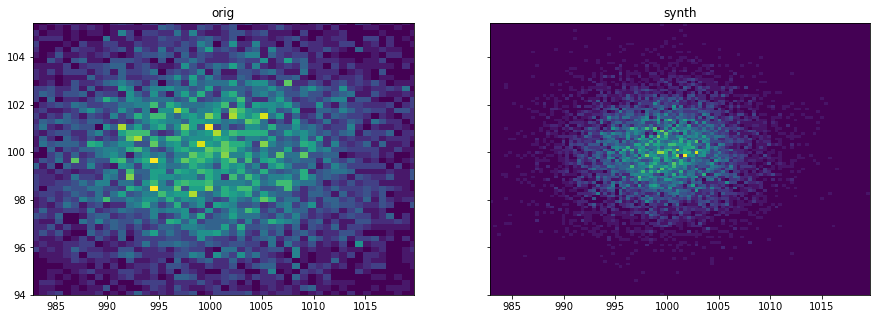

In [15]:
synthesize_and_plot(data, 'ball')

### Gauss "ball" around of zero

In [ ]:
data = create_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'ball_ext')

### Line of noise that far from zero

In [ ]:
data = create_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'line')

### Line of noise that comes from zero

In [ ]:
data = create_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'line_ext')

### Power law distribution

In [ ]:
data = create_power_law_distribution(a=0.5, scale=1000, size=10000)

In [ ]:
synthesize_and_plot(data, 'power_law')

### Conditional distribution

In [ ]:
data = create_conditional_distibution((10,2), (20, 5), (30, 1), size=10000)

In [ ]:
synthesize_and_plot(data, 'conditional')

### Bernoulli distribution

In [ ]:
data = create_bernoulli_distribution(ratio=0.5, size=10000)

In [ ]:
synthesize_and_plot(data, 'bernoulli_50/50')

In [ ]:
data = create_bernoulli_distribution(ratio=0.2, size=10000)

In [ ]:
synthesize_and_plot(data, 'bernoulli_20/80')

### Categorical distribution

In [ ]:
data = create_unifom_categorical(n_classes=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'categorical_uniform')

In [16]:
data = create_power_law_categorical(n_classes=10, size=10000)

took 25.415975093841553 s


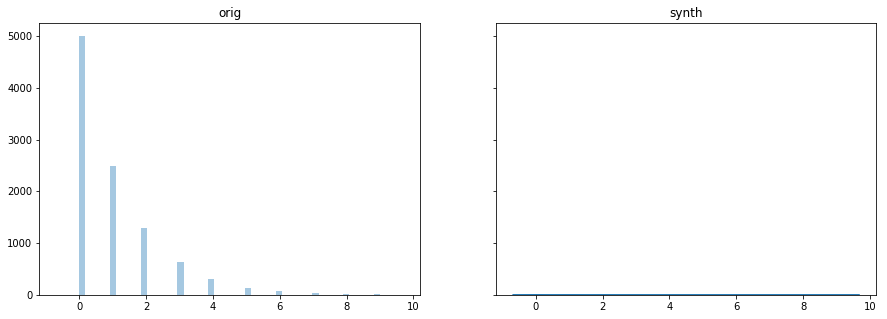

In [17]:
synthesize_and_plot(data, 'categorical_powerlaw')

In [19]:
evaluation.write_metrics()